# Three-Level System: Raman M-Scheme Coupling

Similar to the two-level system we explored before, we will now look at the evolution of a coupled three-level system with the rotating-wave approximation (RWA). The nature of the coupling is once again not too importat, but we will more specifically concern ourselves with a Raman M-scheme, which uses two-photon processes to drive transitions between ground state levels. In the most relevant case, the three spins considered here are the magnetic sub-levels of the $F=1$ ground state hyperfine level in an alkali-metal atom (Rubidium-87). Details of this coupling scheme, and a full derivation of the Hamiltonian are available upon request, or from various sources online; I'll be the first to admit that it's not trivial.

In [51]:
#----- Import Libraries -----
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

## The Hamiltonian

The RWA Hamiltonian is given by,

$$\hat{\mathcal{H}}_{\mathrm{RWA}} = \frac{\Omega}{2}\left( \sin\phi \hat{F}_x + \cos\phi \hat{F}_y \right) - \frac{\delta}{2} \hat{F}_z, $$

where $\hat{F}_j$ are the atomic hyperfine operators representing the total angular momentum in the $j$ basis, $\Omega$ is the Rabi frequency (coupling strength), $\delta$ is the detuning of the field from resonance, and $\phi$ is the phase of the driving field. We've assumed that $\hbar=1$ here. The details of the coupling are in the explicit form of $\Omega$; for our purposes, this coupling depends primarily on the electric fields produced by the Raman lasers (and atomic parameters). Likewise, the detuning $\delta$ can be interpreted as the two-photon detuning from resonance (difference between laser frequencies minus the level-splitting).

In [52]:
#--- Input Parameters ---
Omega = 2*np.pi * 1 #Rabi frequency
phi = np.pi/4 #Driving field phase
delta = 0.1 * Omega #Field detuning

#----- Global Settings -----
sx, sy, sz = qt.operators.jmat(1, 'x'), qt.operators.jmat(1, 'y'), qt.operators.jmat(1, 'z') #Shorthand spin matrices

periods = 4 #Number of periods of Omega to simulate over
t = np.linspace(0, periods*(2*np.pi/Omega), num=500) #Time axis

#--- Initial States ---
psi1, psi2, psi3 = qt.basis(3,0), qt.basis(3,1), qt.basis(3,2) #Three-level basis states
psi = psi1 #Initial state
psi = psi.unit() #Force normalization

#--- Projection Operators ---
p1, p2, p3 = psi1.proj(), psi2.proj(), psi3.proj() #Project onto bare spins (z-basis)
eigx, eigy = sx.eigenstates(), sy.eigenstates() #eigenstates of sx, sy
px1, px2, px3 = eigx[1][0].proj(), eigx[1][1].proj(), eigx[1][2].proj() #Corresponding proj. ops.
py1, py2, py3 = eigy[1][0].proj(), eigy[1][1].proj(), eigy[1][2].proj() #Corresponding proj. ops.

proj_ops = [p1, p2, p3, px1, px2, px3, py1, py2, py3] #All ops. in list

In [53]:
#----- Rotating Wave Approximation -----
Hrwa =  (Omega/2) * (np.sin(phi)*sx + np.cos(phi)*sy) - (delta/2)*sz #RW-Hamiltonian w/ phase

#--- Solve SE ---
Psi = qt.sesolve(Hrwa, psi, t, e_ops=proj_ops) #Solve SE

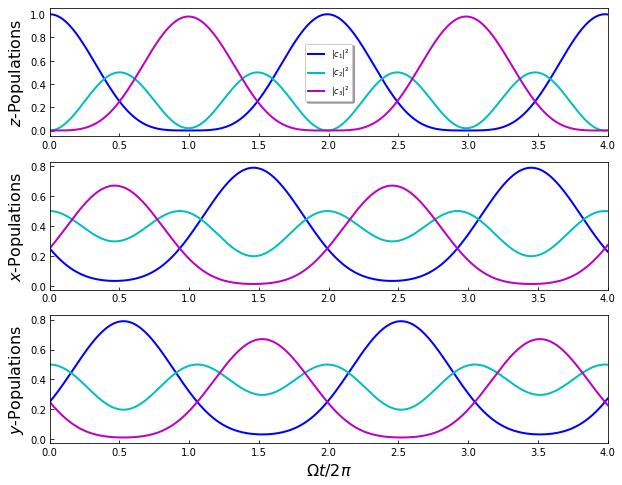

In [54]:
#----- Plot Reuslts -----
fig = plt.figure( figsize=(10,8) )
axb, axs, axc = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
fs = 16 #Label fontsize
labels = ['$|c_{1}|^2$', '$|c_{2}|^2$', '$|c_{3}|^2$'] #Plot labels

#--- Draw Plots ---
axb.plot( Psi.times*(Omega/2/np.pi), Psi.expect[0], 'b-', lw=2, label=labels[0] )
axb.plot( Psi.times*(Omega/2/np.pi), Psi.expect[1], 'c-', lw=2, label=labels[1] )
axb.plot( Psi.times*(Omega/2/np.pi), Psi.expect[2], 'm-', lw=2, label=labels[2] )

axs.plot( Psi.times*(Omega/2/np.pi), Psi.expect[3], 'b-', lw=2, label=labels[0] )
axs.plot( Psi.times*(Omega/2/np.pi), Psi.expect[4], 'c-', lw=2, label=labels[1] )
axs.plot( Psi.times*(Omega/2/np.pi), Psi.expect[5], 'm-', lw=2, label=labels[2] )

axc.plot( Psi.times*(Omega/2/np.pi), Psi.expect[6], 'b-', lw=2, label=labels[0] )
axc.plot( Psi.times*(Omega/2/np.pi), Psi.expect[7], 'c-', lw=2, label=labels[1] )
axc.plot( Psi.times*(Omega/2/np.pi), Psi.expect[8], 'm-', lw=2, label=labels[2] )

#--- Plot Settings ---
axb.set_ylabel('$z$-Populations', fontsize=fs)
axs.set_ylabel('$x$-Populations', fontsize=fs)
axc.set_ylabel('$y$-Populations', fontsize=fs)

axc.set_xlabel('$\Omega t/2\pi$', fontsize=fs) #Comman x-label
axb.legend(loc='best', fancybox=True, shadow=True, framealpha=1, fontsize=8)
for ax in axb, axs, axc:
    ax.set_xlim([0,periods]) #Remove extra spaces at ends
    ax.tick_params(direction='in') #Set grid-ticks inward
plt.show()

## Bloch Sphere: Majorana's Stellar Representation

[paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.240402)

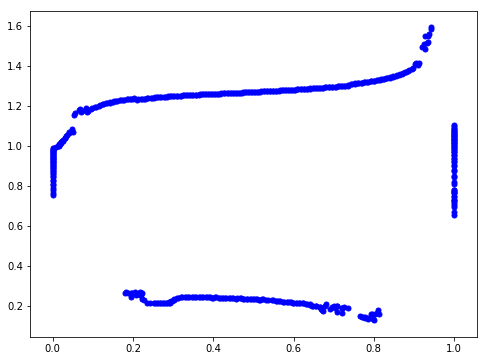

In [55]:
#----- Find States Explicitely -----
Psi = qt.sesolve(Hrwa, psi, t) #Solve SE

#----- Minimize Husimi-Q Function -----
from scipy.optimize import minimize

def qf(angles, state):
    ''' call qt.spin_q_function() to pass to scipy.minimize '''
    q, qth, qph = qt.spin_q_function(state, angles[0], angles[1])
    return q[0][0]

bounds = ([0,np.pi,], [0, 2*np.pi]) #Bounds on theta, phi
x0 = np.pi * np.array([0.5, 1]) #initial guess (theta, phi)
ans = np.empty( (len(Psi.states),2) ) #Empty array for answers

for i, state in enumerate(Psi.states):
    sol = minimize( qf, x0, args=state, bounds=bounds )
    #x0 = np.array([ sol.x[0], sol.x[1] ])
    ans[i,:] = [ sol.x[0], sol.x[1] ]

fig = plt.figure( figsize=(8,6) )
plt.scatter( ans[:,0]/np.pi, ans[:,1]/np.pi, s=25, c='blue', marker='o')
plt.show()

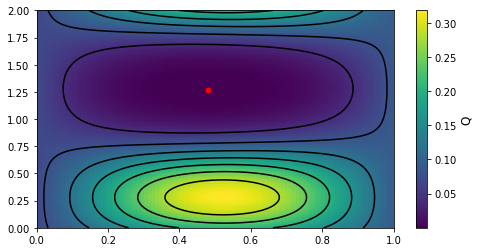

In [56]:
th = np.linspace(0, np.pi, num=100)
ph = np.linspace(0, 2*np.pi, num=100)

ind = 60
state = Psi.states[ind]
q, qth, qph = qt.spin_q_function(state, th, ph)

#--- Plot Results ---
fig = plt.figure( figsize=(8,4) )
fs = 12
qfunc = plt.pcolormesh( qth/np.pi, qph/np.pi, q )
plt.contour( qth/np.pi, qph/np.pi, q, colors='k')
plt.scatter( ans[ind,0]/np.pi, ans[ind,1]/np.pi, s=25, c='red', marker='o')

cb = fig.colorbar(qfunc) #draw colorbar
cb.set_label('Q', fontsize=fs) #label colorbar
plt.show()

In [57]:
from scipy.optimize import root_scalar

def pol(z, state):
    return (state[0]/np.sqrt(2)) * z**2 - state[1]*z + (state[2]/np.sqrt(2))

s = np.array(state)
s = s[:,0]

coeffs1 = [ s[2]/np.sqrt(2), -1*s[1], s[0]/np.sqrt(2) ]
coeffs2 = [ s[0]/np.sqrt(2), s[1], s[2]/np.sqrt(2) ]
z1, z2 = np.roots(coeffs1), np.roots(coeffs2)
print( z1, z2 )

#---------
from scipy.optimize import fsolve

def z_par(x, z):
    #f = np.array([ np.tan(x[0]/2)*np.cos(x[1]) - np.real(z), np.tan(x[0]/2)*np.sin(x[1]) - np.imag(z) ])
    f = np.array([ np.tan(x[0]/2)*np.cos(x[1]) - np.real(z), np.tan(x[0]/2)*np.sin(x[1]) - np.imag(z) ])
    return f

x0 = np.array([ 0,0 ])
sol = fsolve( z_par, x0, args=zs[0] )

print( sol )
print( z_par(sol, zs[0]) )

[0.67302163+0.82452615j 0.68310479+0.81444298j] [-0.60454452+0.7207782j  -0.59412143+0.72786465j]
[   1.63310285 -200.17570631]
[-3.19576254e-10  1.36362477e-10]


In [289]:
def majorana_stars(state):
    ''' Compute Majorana Stars from Qobj() state '''
    
    #--- Compute Char. Polynomial ---
    dim = state.shape[0] #Length of the state
    F = (dim-1)/2 #F-quantum number
    s_as_array = np.array( state )[:,0] #Convert state coeffs to array
    
    coeffs = np.empty(dim, dtype=complex) #List of poly. coeffs
    for i, s in enumerate(np.flip(s_as_array)):
        coeffs[i] = (-1**i) * s / np.sqrt( np.math.factorial(2*F-i)*np.math.factorial(i) )
        if coeffs[i] == 0:
            coeffs[i] = 1e-5 #Set to eps instead to still have n roots
    
    #--- Compute Angles ---
    zj = np.roots( coeffs ) #Find roots
    
    def z_par(x, z):
        ''' Real & Imag parts to zj=tan(th/2)e^{i ph}'''
        re = np.tan(x[0]/2)*np.cos(x[1]) - np.real(z) #Real part
        im = np.tan(x[0]/2)*np.sin(x[1]) - np.imag(z) #Imaginary part
        return np.array([ re, im ])
    
    sol = []
    x = []
    for root in zj:
        xs = fsolve( z_par, [0,0], args=root ) #Solve for the angles
        sol.append([ 
            xs[0]%np.pi, \
            xs[1]%(2*np.pi) ]) #Modulo pi (theta), 2pi (phi)
    return np.array( sol )

#----------
s = Psi.states[0]
s = qt.basis(3,1)
angles = majorana_stars( s )